In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print('measurement - ', c['name'], c["type"])
columns = inspector.get_columns('station')
for c in columns:
    print('station - ', c['name'], c["type"])

measurement -  id INTEGER
measurement -  station TEXT
measurement -  date TEXT
measurement -  prcp FLOAT
measurement -  tobs FLOAT
station -  id INTEGER
station -  station TEXT
station -  name TEXT
station -  latitude FLOAT
station -  longitude FLOAT
station -  elevation FLOAT


# Exploratory Climate Analysis

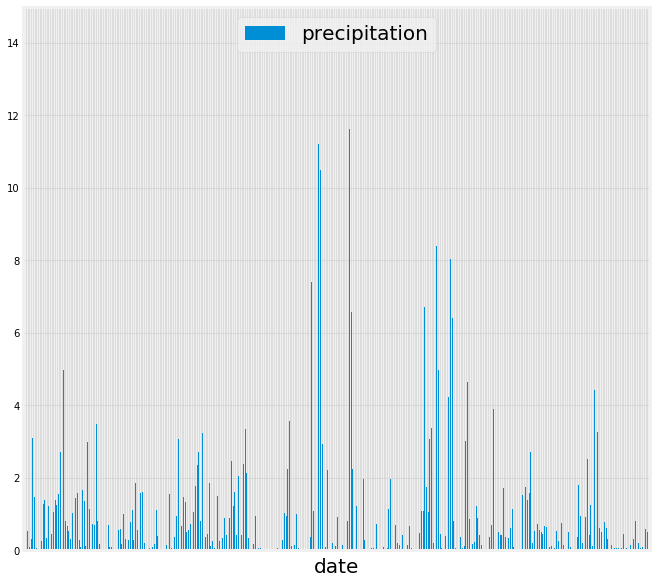

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# engine.execute('SELECT date, prcp FROM measurement').fetchall()

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(desc(Measurement.date)).all()[0][0]
One_yr_ago='2016-08-23'

# Perform a query to retrieve the data and precipitation scores
prcp_lastyear=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date.between(One_yr_ago,last_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_lastyear_df=pd.DataFrame(prcp_lastyear)
prcp_lastyear_df['date'] =pd.to_datetime(prcp_lastyear_df['date'])

# Sort the dataframe by date
prcp_lastyear_df.sort_values(by='date',inplace=True)
prcp_lastyear_grouped=prcp_lastyear_df.groupby('date').sum()

# Use Pandas Plotting with Matplotlib to plot the data
plot_prcp=prcp_lastyear_grouped.plot(kind='bar',figsize=(10,10),xticks=None,rot=90,use_index=True)
plot_prcp.set_xticklabels([])
plot_prcp.legend(['precipitation'],loc='upper center',fontsize=20)
plt.xlabel('date', fontsize=20);
plot_prcp.grid(which='minor', alpha=0.2)
plot_prcp.grid(which='major', alpha=0.5)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_lastyear_grouped.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
# station_lastyear=session.query(Measurement.station,Measurement.prcp).filter(Measurement.date.between(One_yr_ago,last_date)).all()
# station_lastyear_pd=pd.DataFrame(station_lastyear)
# station_num = station_lastyear_pd.groupby('station').count()
stations=session.query(Measurement.station,func.count(Measurement.prcp)).filter(Measurement.date.between(One_yr_ago,last_date)).group_by(Measurement.station)
stations=stations.order_by(func.count(Measurement.prcp).desc()).all()

len(stations)


7

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station, func.count(Measurement.station)).order_by(func.count(Measurement.station).desc()).group_by(Measurement.station).all()
stations_acitve_df=pd.DataFrame(stations_active, columns=["Station", "Station Count"])
stations_acitve_df

,Station,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp =session.query(func.min(Measurement.tobs)).filter_by(station=stations_acitve_df['Station'][0]).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station=stations_acitve_df['Station'][0]).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station=stations_acitve_df['Station'][0]).all()
print("The lowest Temp is", lowest_temp)
print("The highest Temp is", highest_temp)
print("The average Temp is", avg_temp)





The lowest Temp is [(54.0,)]
The highest Temp is [(85.0,)]
The average Temp is [(71.66378066378067,)]


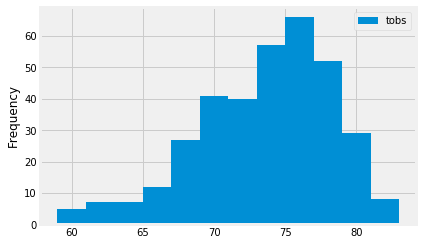

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs = session.query(Measurement.station).order_by(func.count(Measurement.tobs).desc()).group_by(Measurement.station).first()

plot=session.query(Measurement.date, Measurement.tobs).filter_by(station=highest_obs[0]).filter(Measurement.date > One_yr_ago).order_by(Measurement.date.desc()).all()
df_plot = pd.DataFrame(plot, columns=['Date', 'Frequency'])
df_plot.head()

yaxis=(df_plot["Frequency"])
plt.hist(yaxis, bins=12)
legend = ["tobs"]
plt.ylabel("Frequency")
plt.legend(legend)
plt.savefig("Images/histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-23'
end_date = '2017-08-22'
avg_temp = (calc_temps(start_date,end_date))
print(f"The min,average and max temperature  from {start_date} to {end_date} are: {calc_temps(start_date, end_date)[0]}")


The min,average and max temperature  from 2016-08-23 to 2017-08-22 are: (58.0, 74.58041329739443, 87.0)


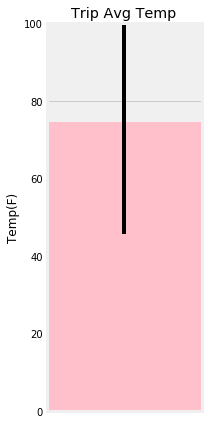

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xaxis=np.arange(1)
yaxis=avg_temp[0][1]
yerror = avg_temp[0][2]-avg_temp[0][0]

plt.figure(figsize=(3,6))
plt.bar(xaxis, yaxis, yerr=yerror, color='pink')
plt.xticks([])
plt.xlim(-0.1,0.1)
plt.ylim(0, 100)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

In [56]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stations=session.query(Measurement,Station,func.sum(Measurement.prcp)).\
filter(Measurement.date.between(start_date,end_date)).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()
for row in stations:
    print(row[0].station,row[1].name,row[1].latitude,row[1].longitude,row[1].elevation,row[2])


USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 147.36000000000007
USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9 70.03000000000003
USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6 48.510000000000026
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 37.93
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 33.239999999999995
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 16.089999999999986
USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9 4.59


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


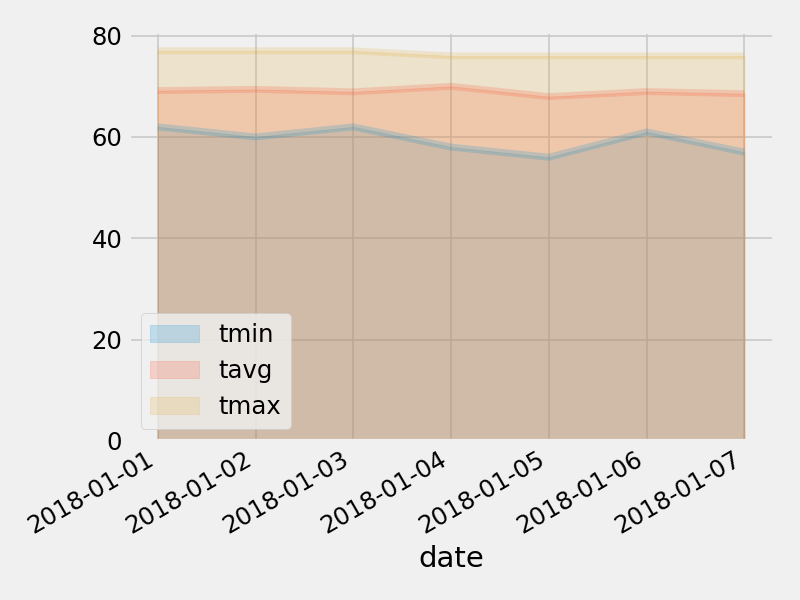

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
